In [1]:
import sys
sys.path.append('../../ml_utils')

import findspark
findspark.init()

from handyspark import *

import data_utils as du
import spark_utils as su
import sentiment_classifier
import timeit

from pyspark import SparkContext, SparkConf
from pyspark.sql import SQLContext
from pyspark.ml.feature import StringIndexer
from pyspark.ml import Pipeline, PipelineModel
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics

### create Spark environment

In [2]:
# spark_endpoint = "spark://spark.home.net:7077"
#base_dir = '/Users/administrator/'

spark_endpoint = "spark://lasvegas:7077"
base_dir = '/home/administrator/'

# these two jars must be added!
spark_jars = base_dir + 'Development/spark-2.4.4-bin-hadoop2.7/jars/spark-nlp_2.11-2.3.3.jar,' + base_dir + '/Development/spark-2.4.4-bin-hadoop2.7/jars/config-1.4.0.jar'

conf = SparkConf().setMaster(spark_endpoint) \
.set("spark.jars", spark_jars) \
.setAppName("Sentiment Analysis")

sc = SparkContext(conf=conf)
sqlContext = SQLContext(sc)
sc.getConf().getAll()

[('spark.sql.execution.arrow.enabled', 'true'),
 ('spark.app.id', 'app-20200112130721-0009'),
 ('spark.master', 'spark://lasvegas:7077'),
 ('spark.executor.id', 'driver'),
 ('spark.repl.local.jars',
  'file:///home/administrator/Development/spark-2.4.4-bin-hadoop2.7/jars/spark-nlp_2.11-2.3.3.jar,file:///home/administrator/Development/spark-2.4.4-bin-hadoop2.7/jars/config-1.4.0.jar'),
 ('spark.jars',
  '/home/administrator/Development/spark-2.4.4-bin-hadoop2.7/jars/spark-nlp_2.11-2.3.3.jar,/home/administrator//Development/spark-2.4.4-bin-hadoop2.7/jars/config-1.4.0.jar'),
 ('spark.driver.host', '192.168.4.5'),
 ('spark.rdd.compress', 'true'),
 ('spark.driver.cores', '6'),
 ('spark.serializer', 'org.apache.spark.serializer.KryoSerializer'),
 ('spark.driver.maxResultSize', '10g'),
 ('spark.executor.cores', '6'),
 ('spark.executor.memory', '20g'),
 ('spark.kryoserializer.buffer.max', '1g'),
 ('spark.driver.memory', '20g'),
 ('spark.serializer.objectStreamReset', '100'),
 ('spark.submit.dep

### read the log statements based on a given schema

In [3]:
log_entries_df = sqlContext.read.format('com.databricks.spark.csv') \
    .schema(su.feature_schema) \
    .options(header = 'false', inferschema = 'false', delimiter = '\t') \
    .load('./../../shared/data/swissid_authorize_logs_april_to_sept_2019.csv')

#log_entries_df.show(2)

In [4]:
#log_entries_df.printSchema()

In [5]:
log_entries_df.count(), len(log_entries_df.columns)

(12417598, 31)

In [6]:
h_df = log_entries_df.toHandy()

In [7]:
h_df.cols['label_nr'].value_counts(dropna=False)

label_nr
0.0    4982015
1.0      22769
2.0    7412814
Name: value_counts, dtype: int64

### filter 'bad' statements and select a subset of all features

In [8]:
reduced_feature_set = True

In [9]:
reduced_df = su.clean_log_entries(log_entries_df, False, False, False, reduced_feature_set, False)

#reduced_df.show(2)

In [10]:
reduced_hdf = reduced_df.toHandy()

In [11]:
#reduced_hdf.cols[:][:5]

In [12]:
reduced_hdf.cols['label_nr'].value_counts(dropna=False)

label_nr
0.0    4769169
1.0      22766
Name: value_counts, dtype: int64

Since we are only interested in detecting log statements with negative sentiment, generate a new label 
whereby if the sentiment is negative, the label is TRUE (Positive Outcome) otherwise FALSE

In [13]:
preprocessed_df = sentiment_classifier.preprocess(reduced_df, False, reduced_feature_set)
#preprocessed_df.show(5, False)

In [14]:
#preprocessed_df.filter('label_nr = 1.0').toHandy().cols[:][:5]

Generate Term Frequency Feature Vectors by passing the sequence of tokens to the HashingTF Transformer.
Then fit an IDF Estimator to the Featurized Dataset to generate the IDFModel.
Finally pass the TF Feature Vectors to the IDFModel to scale based on frequency across the corpus

In [15]:
encoded_features_df = sentiment_classifier.vectorize(preprocessed_df, False)
encoded_features_df.cache()
#encoded_features_df.show(1, False)

DataFrame[label_nr: double, text: string, tokens: array<string>, features: vector]

In [16]:
#encoded_features_df.filter('label_nr = 1.0').toHandy().cols[:][:5]

Split the index-labelled Scaled Feature Vectors into Training and Test DataFrames

In [17]:
train_df, test_df = encoded_features_df.randomSplit([0.8, 0.2], seed=12345)
train_df.count(), test_df.count()

(3833427, 958508)

## Hyperparameter Tuning

In [18]:
clf = DecisionTreeClassifier(labelCol="label_nr", featuresCol="features", maxDepth=3)

In [19]:
# Create ParamGrid for Cross Validation
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

paramGrid = (ParamGridBuilder()
             .addGrid(clf.maxDepth, [1, 2, 6, 10])
             .addGrid(clf.maxBins, [20, 40, 80])
             .build())

In [20]:
evaluator = BinaryClassificationEvaluator(labelCol='label_nr')

In [21]:
# Create 5-fold CrossValidator
cv = CrossValidator(estimator=clf, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=5)

# Run cross validations
start = timeit.default_timer()
cvModel = cv.fit(train_df)
stop = timeit.default_timer()

print("Time: {} seconds\n".format(stop - start))

Time: 220.1379990489986 seconds



In [22]:
print("numNodes = ", cvModel.bestModel.numNodes)
print("depth = ", cvModel.bestModel.depth)

numNodes =  25
depth =  6


### Train a Classification Tree Model on the Training DataFrame

In [23]:
clf = DecisionTreeClassifier(featuresCol = 'features', labelCol = 'label_nr', 
                             maxDepth=cvModel.bestModel.depth,
                             maxBins=cvModel.bestModel.numNodes)
model = clf.fit(train_df)

Apply the Trained Classification Tree Model to the Test DataFrame to make predictions

In [24]:
predictions_df = model.transform(test_df)

In [25]:
#print("TEST DATASET PREDICTIONS AGAINST ACTUAL LABEL: ")
#predictions_df.select("prediction", "label_nr", "tokens").toHandy().cols[:][:5]

In [26]:
#predictions_df.filter('label_nr = 1.0').select("prediction", "label_nr", "tokens").toHandy().cols[:][:5]

Compute the Confusion Matrix for our Decision Tree Classifier on the Test DataFrame

In [27]:
predictions_and_label = predictions_df.select("prediction", "label_nr").rdd
metrics = MulticlassMetrics(predictions_and_label)

print("N = %g" % predictions_df.count())
print(metrics.confusionMatrix().toArray())
print("numOfNodes = ", model.numNodes)
print("depth = ", model.depth)

N = 958508
[[9.53937e+05 0.00000e+00]
 [8.00000e+00 4.56300e+03]]
numOfNodes =  25
depth =  6


In [28]:
predictions_df.printSchema()

root
 |-- label_nr: double (nullable = true)
 |-- text: string (nullable = false)
 |-- tokens: array (nullable = false)
 |    |-- element: string (containsNull = true)
 |-- features: vector (nullable = true)
 |-- rawPrediction: vector (nullable = true)
 |-- probability: vector (nullable = true)
 |-- prediction: double (nullable = false)



## Evaluation

In [29]:
evaluator = BinaryClassificationEvaluator(labelCol='label_nr')
print('Test Area Under ROC', evaluator.evaluate(predictions_df))

Test Area Under ROC 0.9990184224335085


In [30]:
bcm = BinaryClassificationMetrics(predictions_df, scoreCol='probability', labelCol='label_nr')

In [31]:
bcm.areaUnderROC

0.999018411196126

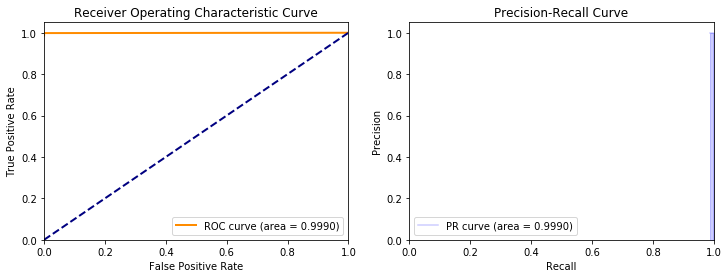

In [32]:
from matplotlib import pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(12, 4))
bcm.plot_roc_curve(ax=axs[0])
bcm.plot_pr_curve(ax=axs[1])

In [33]:
predictions_df.select("label_nr", "prediction", "probability").toHandy().cols[:][:5]

/home/administrator/Development/spark-2.4.4-bin-hadoop2.7/python/pyspark/sql/dataframe.py:2103: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.enabled' is set to true; however, failed by the reason below:
  Unsupported type in conversion to Arrow: VectorUDT
Attempting non-optimization as 'spark.sql.execution.arrow.fallback.enabled' is set to true.
  warnings.warn(msg)


,label_nr,prediction,probability
0,0.0,0.0,"[0.9999868517450101, 1.3148254989894251e-05]"
1,0.0,0.0,"[0.9999868517450101, 1.3148254989894251e-05]"
2,0.0,0.0,"[0.9999868517450101, 1.3148254989894251e-05]"
3,0.0,0.0,"[0.9999868517450101, 1.3148254989894251e-05]"
4,0.0,0.0,"[0.9999868517450101, 1.3148254989894251e-05]"


In [34]:
pdf = bcm.getMetricsByThreshold().toPandas()
pdf

,threshold,fpr,recall,precision
0,1.000000,0.000000,0.986874,1.000000
1,0.981818,0.000000,0.998250,1.000000
2,0.045455,0.000007,0.998250,0.998468
3,0.000013,0.996704,0.999781,0.004784
4,0.000000,1.000000,1.000000,0.004769
5,0.000000,1.000000,1.000000,0.000000


In [35]:
bcm.print_confusion_matrix(.50)

Predicted        
                 0       1
Actual 0  953937.0     0.0
       1       8.0  4563.0

In [36]:
bcm.print_confusion_matrix(.90)

Predicted        
                 0       1
Actual 0  953937.0     0.0
       1       8.0  4563.0

In [37]:
def f1_score(pdf, index):
    r = pdf['recall'][index]
    p = pdf['precision'][index]
    return (2 * p * r) / (p + r)

In [38]:
def max_f1_score(pdf):
    max_f1 = 0
    thres = 0
    for i in range(pdf.shape[0]):
        f1 = f1_score(pdf,i)
        if f1 > max_f1:
            max_f1 = f1
            thres = pdf['threshold'][i]
            
    return thres, max_f1

In [39]:
thres, f1 = max_f1_score(pdf)
thres, f1 

(0.9818181818181818, 0.9991241515217867)

In [40]:
# Persist the trained Decision Tree Classifier to disk for later use
model.write().overwrite().save('./../../shared/models/sentiment/overall/optimized')